In [260]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## 1. Quick Mathematical Prelude

Consider a function of the form $f:{\rm I\!R}^{m\times n} \to {\rm I\!R}$ (that maps matrices to scalars). An example of such a function is $f(A) = \|Ax + b\|_2^2$ (where $x$ and $b$ are constant). The derivative of $f$ with respect to $A$ is a function $\frac{\partial f(A)}{\partial A}$ is a matrix-valued function such that
$$\left(\frac{\partial f(A)}{\partial A}\right)_{i,j} = \frac{\partial f(A)}{\partial A_{i, j}}.$$
In what follows we will use the formula
$$\frac{\partial \|Ax-b\|_2^2}{\partial A} = (Ax-b)x^\intercal.$$

## 2. Identification of linear systems

Consider the dynamical system
$$x_{t+1} = Ax_t + w_t,$$
with the following assumptions:
1. The noise, $w_t$, is iid, independent of the state, and has zero mean
2. We can directly measure the state, $x_t$, and we have collected a set of measurements $x_0, \ldots, x_N$
3. The matrix $A$ is unknown and we need to estimate it


### 2.1. The least squares approach

At every time $t=0,\ldots, N-1$, the error is $w_t = Ax_t - x_{t+1}$. We can define the total error as
$$e = \sum_{t=0}^{N-1}\|w_t\|_2^2 = \sum_{t=0}^{N-1}\|Ax_t - x_{t+1}\|_2^2.$$
This is a function of $A$ and
$$\frac{\partial e(A)}{\partial A} = \sum_{t=0}^{N-1} (Ax_t - x_{t+1})x_t^\intercal = \sum_{t=0}^{N-1} Ax_tx_t^\intercal - \sum_{t=0}^{N-1} x_{t+1}x_t^\intercal.$$
In order to determine the value of $A$ that minimises the error we will set the derivative to zero and solve for $A$; we have
$$A \cdot \sum_{t=0}^{N-1} x_tx_t^\intercal = \sum_{t=0}^{N-1} x_{t+1}x_t^\intercal.$$
Provided $N > n$ chances are that $\sum_{t=0}^{N-1} x_tx_t^\intercal$ is full rank, thus invertible, so we can solve the above equation.

### 2.2. Implementation
Let $X = [x_0 ~ \cdots ~ x_{N-1}]$ and $X^+ = [x_1 ~ \cdots ~ x_N]$. Then, the above equation becomes
$$A XX^\intercal = X^{+}X^\intercal \Leftrightarrow XX^\intercal A^\intercal = XX^{+\intercal}$$
We can now solve this with [`np.linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) to determine $A^\intercal$.

### 2.3. Notation

Hereafter, we will denote the unknown matrix by $A$ and the estimated matrix using $N$ samples by $\hat{A}_N$.

## 3. Example

Consider a system with
$$A = \begin{bmatrix}0.8 & 0.1 & 0.1 \\ -0.1 & 0.8 & -0.2 \\ 0 & 0 & 0.5\end{bmatrix},$$
and $w_t \overset{\text{iid}}{\sim} \mathcal{N}(0, Q)$ with $Q = 0.01 \cdot I_3$. Let us generate $N$ states starting from $x_0=(1, 1, 1)$.

In [271]:
np.random.seed(1)

A = np.array([[0.8, -0.1, 0.1],
              [-0.1, 0.8, -0.2],
              [0, 0, 0.5]])
nx = A.shape[0]
n_samples = 10000
Q = 0.01 * np.eye(nx)
X = np.zeros((nx, n_samples+1))
X[:, 0] = np.array([1, 1, 1])
for t in range(n_samples):
    wt = np.random.multivariate_normal(np.zeros(nx), Q)
    X[:, t+1] = A @ X[:, t] + wt

XXt = X[:, :n_samples-1] @ X[:, :n_samples-1].T
XplusXt = X[:, :n_samples-1] @ X[:, 1:n_samples].T

A_LS_estimate = np.linalg.solve(XXt, XplusXt).T
print(np.linalg.norm(A_LS_estimate - A))

0.023732540583616766


**Exercise:** Once we have estimated the system matrix, we naturally want to evaluate the quality of our estimation; we compute two things: the **bias**, which is the norm of the average $\hat{w}_t = x_{t+1} - \hat{A}_N x_t$, that is
$$\widehat{\mathrm{bias}}_N = \left\|\mu^w_N\right\|,$$
where $\mu^w_N$ is the average $w$, i.e.,
$$\mu^w_N = \tfrac{1}{N}\sum_{t=0}^{N-1}\hat{w}_t.$$
Note that $\widehat{\mathrm{bias}}_N$ is a scalar, whereas $\mu^w_N\in{\rm I\!R}^{n_x}$ is a vector.

It is also useful to estimate the **variance** of $\|w_t\|^2$; this can be estimated by
$$\hat{s}_N^2 = \tfrac{1}{N}\sum_{t=0}^{N-1} \|\hat{w}_t - \mu^w_N\|^2.$$

> **Caveat:** Sometimes we see in the machine learning literature either $\hat{s}_N^2$ or its square root (known as the [RMSE](https://en.wikipedia.org/wiki/Root_mean_square_deviation)) being used as the sole criterion for the quality of our estimate. For reasons that will become clearer later, this is not a good idea. Here's a trivial example: if you have obtained only two measurements, you'll have a single $w$. The variance will be zero. However, the bias will be likely large. Even if both the bias and the variance are small, if your number of samples is too small (?), it's likely you were "lucky" (or unlucky?!). We will not go into further detail regarding how many samples are too few. Just keep in mind: we need to have a critical attitude towards our results. We'll look at a few examples below.

In [262]:
# Your code goes here

## 4. Exercise

Consider the system
$$x_{t+1} = \underbrace{\begin{bmatrix}0.8 & 0.1 & 0.1 & 0.3\\ -0.1 & 0.8 & -0.2 & 0\\ 0 & 0 & 0.5 & -0.5 \\ 0.1 & 0.2 & -0.1 & 0.05\end{bmatrix}}_{A}x_t + \begin{bmatrix}0\\0\\1\end{bmatrix}u_t + w_t,$$
where $w_t \overset{\text{iid}}{\sim} \mathcal{N}(0, Q)$ with $Q = 0.01 \cdot I_4$ and $u_t$ are *known* inputs. Suppose that matrix $A$ is unknown and estimate it using observations $x_0, \ldots, x_N$ and inputs $u_0, \ldots, u_{N-1}$. Choose a sequence of inputs $u_0, \ldots, u_{N-1}$ and estimate $A$ using the least squares method. You can choose the inputs to be iid samples of a random variable, e.g., $u_t\overset{\text{iid}}{\sim}\mathcal{N}(0, 1)$. Experiment with different values of $N$ and plot $\widehat{e}_N$ against $N$.

In [ ]:
# Your code goes here
A_actual = np.array([[0.8, 0.1, 0.1, 0.3],
                     [-0.1, 0.8, -0.2, 0],
                     [0, 0, 0.5, -0.5],
                     [0.1, 0.2, -0.1, 0.05]])


## 5. Constrained estimation

More often than not we don't want to estimate the entire matrix $A$. We may know for example that certain elements of $A$ are zero, or are equal to a certain value. For example, we may know that the system dynamics is 
$$x_{t+1} = \begin{bmatrix}\textcolor{red}{0} & \textcolor{red}{1} \\ \textcolor{blue}{a_{2, 1}} & \textcolor{red}{-1}\end{bmatrix}x_t + w_t,$$
where the only unknown is $a_{2, 1}$ (the elements in red are **known** and fixed; we only need to determine $a_{2,1}$).

Suppose that we know that for certain indices $(i, j)\in \mathcal{I}$, the elements of $A$ are know and equal to some $\bar{a}_{i, j}$, i.e., $A_{i, j} = \bar{a}_{i, j}$ for $(i, j)\in \mathcal{I}$. In the above example, it is 
$$\mathcal{I}=\{(1, 1), (1, 2), (2,2)\},$$
i.e., the elements at $(1, 1)$, $(1, 2)$, and $(2, 2)$ are known and are equal to $\bar{a}_{1, 1} = 0$, $\bar{a}_{1, 2} = 1$, and $\bar{a}_{2, 2} = -1$.

Hereafter we denote the number of known elements by $K$.

In such cases we need to solve the following **constrained** optimisation problem
$$\begin{align*}
\operatorname*{Minimise}_{A\in{\rm I\!R}^{n\times n}} 
&\sum_{t=0}^{N-1}\|Ax_t - x_{t+1}\|_2^2
\\
\text{subject to }& A_{i, j} = \bar{a}_{i, j}, \text{ for } (i, j) \in \mathcal{I}.
\end{align*}$$

This can be solved using the [KKT theorem](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions). Next we will describe the methodology for determining $A$. You can find the proof in the lecture notes.

### 5.1. Solution of constrained estimation problem

**Step 1 (Vector $\bar{a}$):** Collect the $\bar{a}_{i, j}$ in a vector $\bar{a} \in {\rm I\!R}^{K}$ in [column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order). 

**Step 2 (Matrix $\Gamma$):** Suppose we have the set of index pairs
$$\mathcal{I}=\{(i_1, j_1), (i_2, j_2), \ldots, (i_K, j_K)\},$$
We construct the matrix $\Gamma \in {\rm I\!R}^{n^2\times K}$ with
$$\Gamma_{\iota, s} = 
\begin{cases}1, & \text{ if } \iota = (j_s-1)n + i_s \\
0, &\text{ otherwise}\end{cases}$$

**Step 3 (Computatioj of $B$ and $c$):** We define $\tilde{x}_t = x_t \otimes I_n$, where $\otimes$ stands for the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product), and $I_n$ is the $n\times n$ identity matrix. We then define 
$$\begin{align*}
B ={}& \sum_{t=0}^{N-1}\tilde{x}_t \tilde{x}_t^\intercal,
\\
c={}& \sum_{t=0}^{N-1}\tilde{x}_t x_{t+1}.
\end{align*}$$
Note that $B\in{\rm I\!R}^{n^2\times n^2}$ and $c\in {\rm I\!R}^{n^2}$.

**Step 4 (Solution):** Define the vector $\lambda = (\Gamma^\intercal B^{-1} \Gamma)^{-1}(\Gamma^\intercal B^{-1}c - \bar{a})$ ($\lambda \in {\rm I\!R}^{K}$) and 
$$a = B^{-1}(c - \Gamma \lambda).$$
The vector $a\in{\rm I\!R}^{n^2}$ contains the elements of $A$ in [column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order) (see example below).


### 5.2. Example

Consider the system 
$$x_{t+1} = \begin{bmatrix}
\textcolor{red}{-0.9} & \textcolor{blue}{a_{1,2}} &\textcolor{red}{0.1}\\
\textcolor{red}{0}   &\textcolor{red}{1}    &\textcolor{blue}{a_{2, 3}}\\
\textcolor{red}{0}   &\textcolor{blue}{a_{3, 2}}    &\textcolor{red}{0.95}\end{bmatrix}x_t + w_t,$$
where the red entries are fixed. 
We have recorded a sequence of states in the file `example_5.2.csv`.
We have 
$$\mathcal{I} = \{(1, 1), (2, 1), (3, 1), (2, 2), (1, 3), (3, 3)\},$$
where we have arranged the pairs of indices in [column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order). The corresponding known entries are 
$$\bar{a}=(-0.9, 0, 0, 1,  0.1, 0.95).$$
Now in Python...

In [264]:
# Step 1: pairs of indices of fixed/known elements and corresponding values
idx = [(1, 1), (2, 1), (3, 1), (2, 2), (1, 3), (3, 3)]
a_bar = np.array([-0.9, 0, 0, 1,  0.1, 0.95]).reshape(-1, 1)

Let us now create $\Gamma$ in Python...

In [265]:
# Step 2: compute matrix Gamma
nI = len(idx)
nx = 3

Gam = np.zeros((nx**2, nI))
for s in range(nI):
    i_s = idx[s][0]
    j_s = idx[s][1]
    iot_s = (j_s-1)*nx + i_s 
    Gam[iot_s - 1 , s] = 1

Now let us compute $B$ and $c$ in Python. We will use the data in `example_5.2.csv`. This file contains 100,000 data points. At this stage, use the first 2,000 only. To read the csv file, we can use

In [266]:
# Step 3: Compute B and c
states = np.genfromtxt('data/example_5.2.csv', delimiter=',') # Read data from file
states = states[:, :2000]  # remove time column
n_samples = states.shape[0]
B = 0; c = 0
for t in range(n_samples-1):
    x = states[t, :].reshape(-1, 1)
    x_plus = states[t+1, :].reshape(-1, 1)
    x_tilde = np.kron(x, np.eye(nx))
    B = B + x_tilde @ x_tilde.T
    c = c + x_tilde @ x_plus

and now let us determine $\lambda$

In [267]:
# Step 4a: Compute lambda
t1 = np.linalg.solve(B, c) # this is B^{-1}*c
t2 = Gam.T @ t1 - a_bar
t3 = np.linalg.solve(B, Gam)
lam = np.linalg.solve(Gam.T@t3, t2)

we can now estimate $A$...

In [268]:
# Step 4b: compute estimated matrix
a_est = np.linalg.solve(B, c - Gam @ lam)
A_estimated = a_est.reshape(nx, nx).T  # just rephrase to get estimated A
np.set_printoptions(precision=4, suppress=True)
print(A_estimated)

[[-0.9     0.5007  0.1   ]
 [ 0.      1.      0.1399]
 [ 0.     -0.2993  0.95  ]]


Let us now compute the bias and variance for different values of $N$

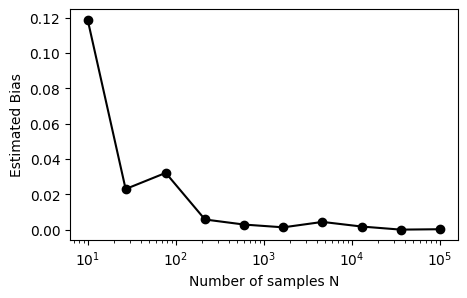

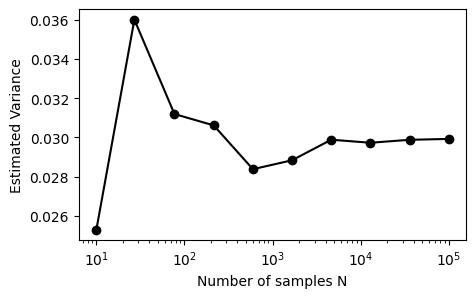

In [ ]:
def estimate_evaluate(N):
    states = np.genfromtxt('data/example_5.2.csv', delimiter=',')
    B_N = 0; c_N = 0
    for t in range(N-1):
        x = states[t, :].reshape(-1, 1)
        x_plus = states[t+1, :].reshape(-1, 1)
        x_tilde = np.kron(x, np.eye(nx))
        B_N = B_N + x_tilde @ x_tilde.T
        c_N = c_N + x_tilde @ x_plus
    t1_N = np.linalg.solve(B_N, c_N)
    t2_N = Gam.T @ t1_N - a_bar
    t3_N = np.linalg.solve(B_N, Gam)
    lam_N = np.linalg.solve(Gam.T @ t3_N, t2_N)
    a_est_N = np.linalg.solve(B_N, c_N - Gam @ lam_N)
    A_est_N = a_est_N.reshape(nx, nx).T
    # Estimate bias
    mu_N = 0
    for t in range(N-1):
        x = states[t, :].reshape(-1, 1)
        x_plus = states[t+1, :].reshape(-1, 1)
        w_hat_t = x_plus - A_est_N @ x
        mu_N = mu_N + w_hat_t
    mu_N = mu_N / (N-1)
    bias_N = np.linalg.norm(mu_N)
    # Estimate variance 
    var_N = 0
    for t in range(N-1):
        x = states[t, :].reshape(-1, 1)
        x_plus = states[t+1, :].reshape(-1, 1)
        w_hat_t = x_plus - A_est_N @ x
        var_N += np.linalg.norm(w_hat_t - mu_N)**2
    var_N = var_N / (N-1)
    return bias_N, var_N, A_est_N

est_err_cache = []
est_var_cache = []
Ns = np.logspace(1, 5, 10).astype(int)
for N in Ns:
    e_est_N, var_N, _ = estimate_evaluate(N)
    est_err_cache.append(e_est_N)
    est_var_cache.append(var_N)

plt.figure(figsize=(5, 3))
plt.semilogx(Ns, est_err_cache, '-ko')
plt.xlabel('Number of samples N')
plt.ylabel('Estimated Bias')  
plt.show()

plt.figure(figsize=(5, 3))
plt.semilogx(Ns, est_var_cache, '-ko')
plt.xlabel('Number of samples N')
plt.ylabel('Estimated Variance')  
plt.show()


**Question:** what do you think happens as $N\to\infty$?

**See next:** [n4sid](./2_n4sid.ipynb) and [Tutorial](./3_tutorial.ipynb)